# Evaluating Gene Correlations - First heart field

In [1]:
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import datetime
import time
import os
import scanpy as sc
import sklearn.metrics
import seaborn as sns
from scipy import sparse
import scipy
import math


import matplotlib
from scipy.spatial import cKDTree
import sys
sys.path.append('/home/icb/manuel.gander/Reproducibility_TOME/Utils')

# Utils contains some functions I use a lot
import Utils

#sc.settings.verbosity = 0

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11,6)})

In [2]:
Path="/home/icb/manuel.gander/Reproducibility_TOME/Data"

# Define time points
t=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[8.5]+[9.5+x for x in range(0,5)]
ts=[str(a) for a in [3.5, 4.5, 5.25, 5.5, 6.25]] + [str(a) for a in np.arange(6.5, 8.5, 0.25)] + ['8.5a', '8.5b']+ [str(a) for a in np.arange(9.5, 14.5, 1)]
ts=['E'+a for a in ts]

t2=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[9.5+x for x in range(0,5)]

# Growth of embryo:
#    - cells corresponds to the estimated total amount of cells in the embryo for each time point
#    - av_g corresponds to the average grwoth rate of the embryo at each specific time point
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 200000, 1100000, 2600000, 6000000, 13000000 ]
av_g=np.zeros(len(t2)-1)
for j in range(0,len(av_g)):
    av_g[j]=cells[j+1]/cells[j]/(t2[j+1]-t2[j])

In [3]:
def load_gr(A0, ts0, ts1, eps, no_gr=False):

    # Loads the output from the KNN-approach and for Moscot

    Dict0=np.load(f"{Path}/TOME-maps/Gene_cor_apop_{ts0}.npy", allow_pickle=True)
    Dict0 = dict(enumerate(Dict0.flatten(), 1))[1]
    
    if no_gr:
        Dict1=np.load(f"{Path}/Moscot-maps/Map_{ts0}_{ts1}_{eps}_giv_lam_no_gr.npy", allow_pickle=True)
    else:
        Dict1=np.load(f"{Path}/Moscot-maps/Map_{ts0}_{ts1}_{eps}_giv_lam.npy", allow_pickle=True)
        
    Dict1 = dict(enumerate(Dict1.flatten(), 1))[1]

    # TOME=KNN-growth rates
    gT=Dict0['g']

    # Moscot growth rates
    gM=Dict1['gr']

    gT=gT/gT.mean()
    gM=gM/gM.mean()

    # Check if the ordering of the growth rates corresponds to the ordering in adata:
    cellids=[a for a in A0.obs['cellID']]
    if [a for a in Dict0['A0_cellID']]==cellids and [a for a in Dict1['A0_cellID']]==cellids:
        return(gT, gM, Dict1['converged'], Dict1['f_apop'])
    else:
        print('ERROR: Cells are not ordered the same!!!')
        return(np.NaN)

In [62]:
i=12
ts0=ts[i]
print('------------------------------------------------------------------------')
print(ts0)
ts1=ts[i+1]

# Load the adata
(A0, A1)=Utils.load_adata(ts0, ts1)

------------------------------------------------------------------------
E8.25


In [63]:
(gT, gM, conv, apop)=load_gr(A0, ts0, ts1, 0.01, no_gr=True)

t0=t[i]
t1=t[i+1]
gT=gT*av_g[i]*(t1-t0)
gM=gM*av_g[i]*(t1-t0)

ct=[a for a in A0.obs['cell_type']]

In [64]:
DF=pd.DataFrame({})

dfT=pd.DataFrame({'Timepoint': ts0, 'Method': 'TOME', 'Growth rate':gT, 'Cell type':ct})
dfM=pd.DataFrame({'Timepoint': ts0, 'Method': 'Moscot', 'Growth rate':gM, 'Cell type':ct})

DF=pd.concat([DF, dfT,dfM])
DF.index=np.arange(len(DF))

In [65]:
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)

['default', 'despine']


In [88]:
cts=A0.obs['cell_type'].astype('category').cat.categories
l=[]
for cellt in cts:
    ctyps=A0.obs['cell_type']
    print(f'{cellt} has {len(A0[ctyps==cellt])/len(A0)*100}%')
    
    if len(A0[ctyps==cellt])/len(A0)>0.05:
        l.append(cellt)

Allantois has 3.7517576377348845%
Amniochorionic mesoderm A has 3.540841109548767%
Amniochorionic mesoderm B has 2.5885210277387194%
Blood progenitors has 1.0673654608206569%
Caudal lateral epiblast has 1.7192892752141122%
Caudal neuroectoderm has 0.5177042055477439%
Definitive endoderm has 0.15978524862584687%
Endothelium has 2.3584302697174997%
Extraembryonic mesoderm has 6.436149814649111%
Extraembryonic visceral endoderm has 3.8476287869103927%
First heart field has 2.0005113127956027%
Forebrain/midbrain has 8.31522433848907%
Gut has 2.63965230729899%
Hematoendothelial progenitors has 2.9080915249904127%
Hindbrain has 4.595423750479355%
Intermediate mesoderm has 0.6071839447782181%
Neural crest has 1.6745494055988752%
Neuromesodermal progenitors has 6.2955387958583655%
Notochord has 0.409050236482168%
Paraxial mesoderm A has 8.149047679918189%
Paraxial mesoderm B has 5.362392943883421%
Paraxial mesoderm C has 1.0162341812603861%
Primitive erythroid cells has 9.65102901700115%
Primo

In [89]:
DFs=DF[DF['Cell type'].isin(l)]

In [90]:
dfms=DFs[DFs['Method']=='Moscot']
dfms=dfms.sort_values('Cell type')
dfts=DFs[DFs['Method']=='TOME']
dfts=dfts.sort_values('Cell type')
dfms['Predicted Number of Descentants']=dfms['Growth rate']
dfts['Predicted Number of Descentants']=dfts['Growth rate']

# Move moscot on top

In [91]:
def change_pal_order(pal,i,j):
    paln=pal.copy()
    paln[i]=pal[j]
    paln[j]=pal[i]
    return(paln)
pal=sns.color_palette('colorblind')
pal2=sns.color_palette()
pal=[pal[i] for i in [0,1,2,3]]
pal=change_pal_order(pal,1,2)
pal=change_pal_order(pal,2,3)
pal[2]=np.array(pal2[3])*0.4+np.array(pal[2])*0.6
pal[0]=np.array([0,0,139])/256*0.25+np.array(pal[0])*0.75

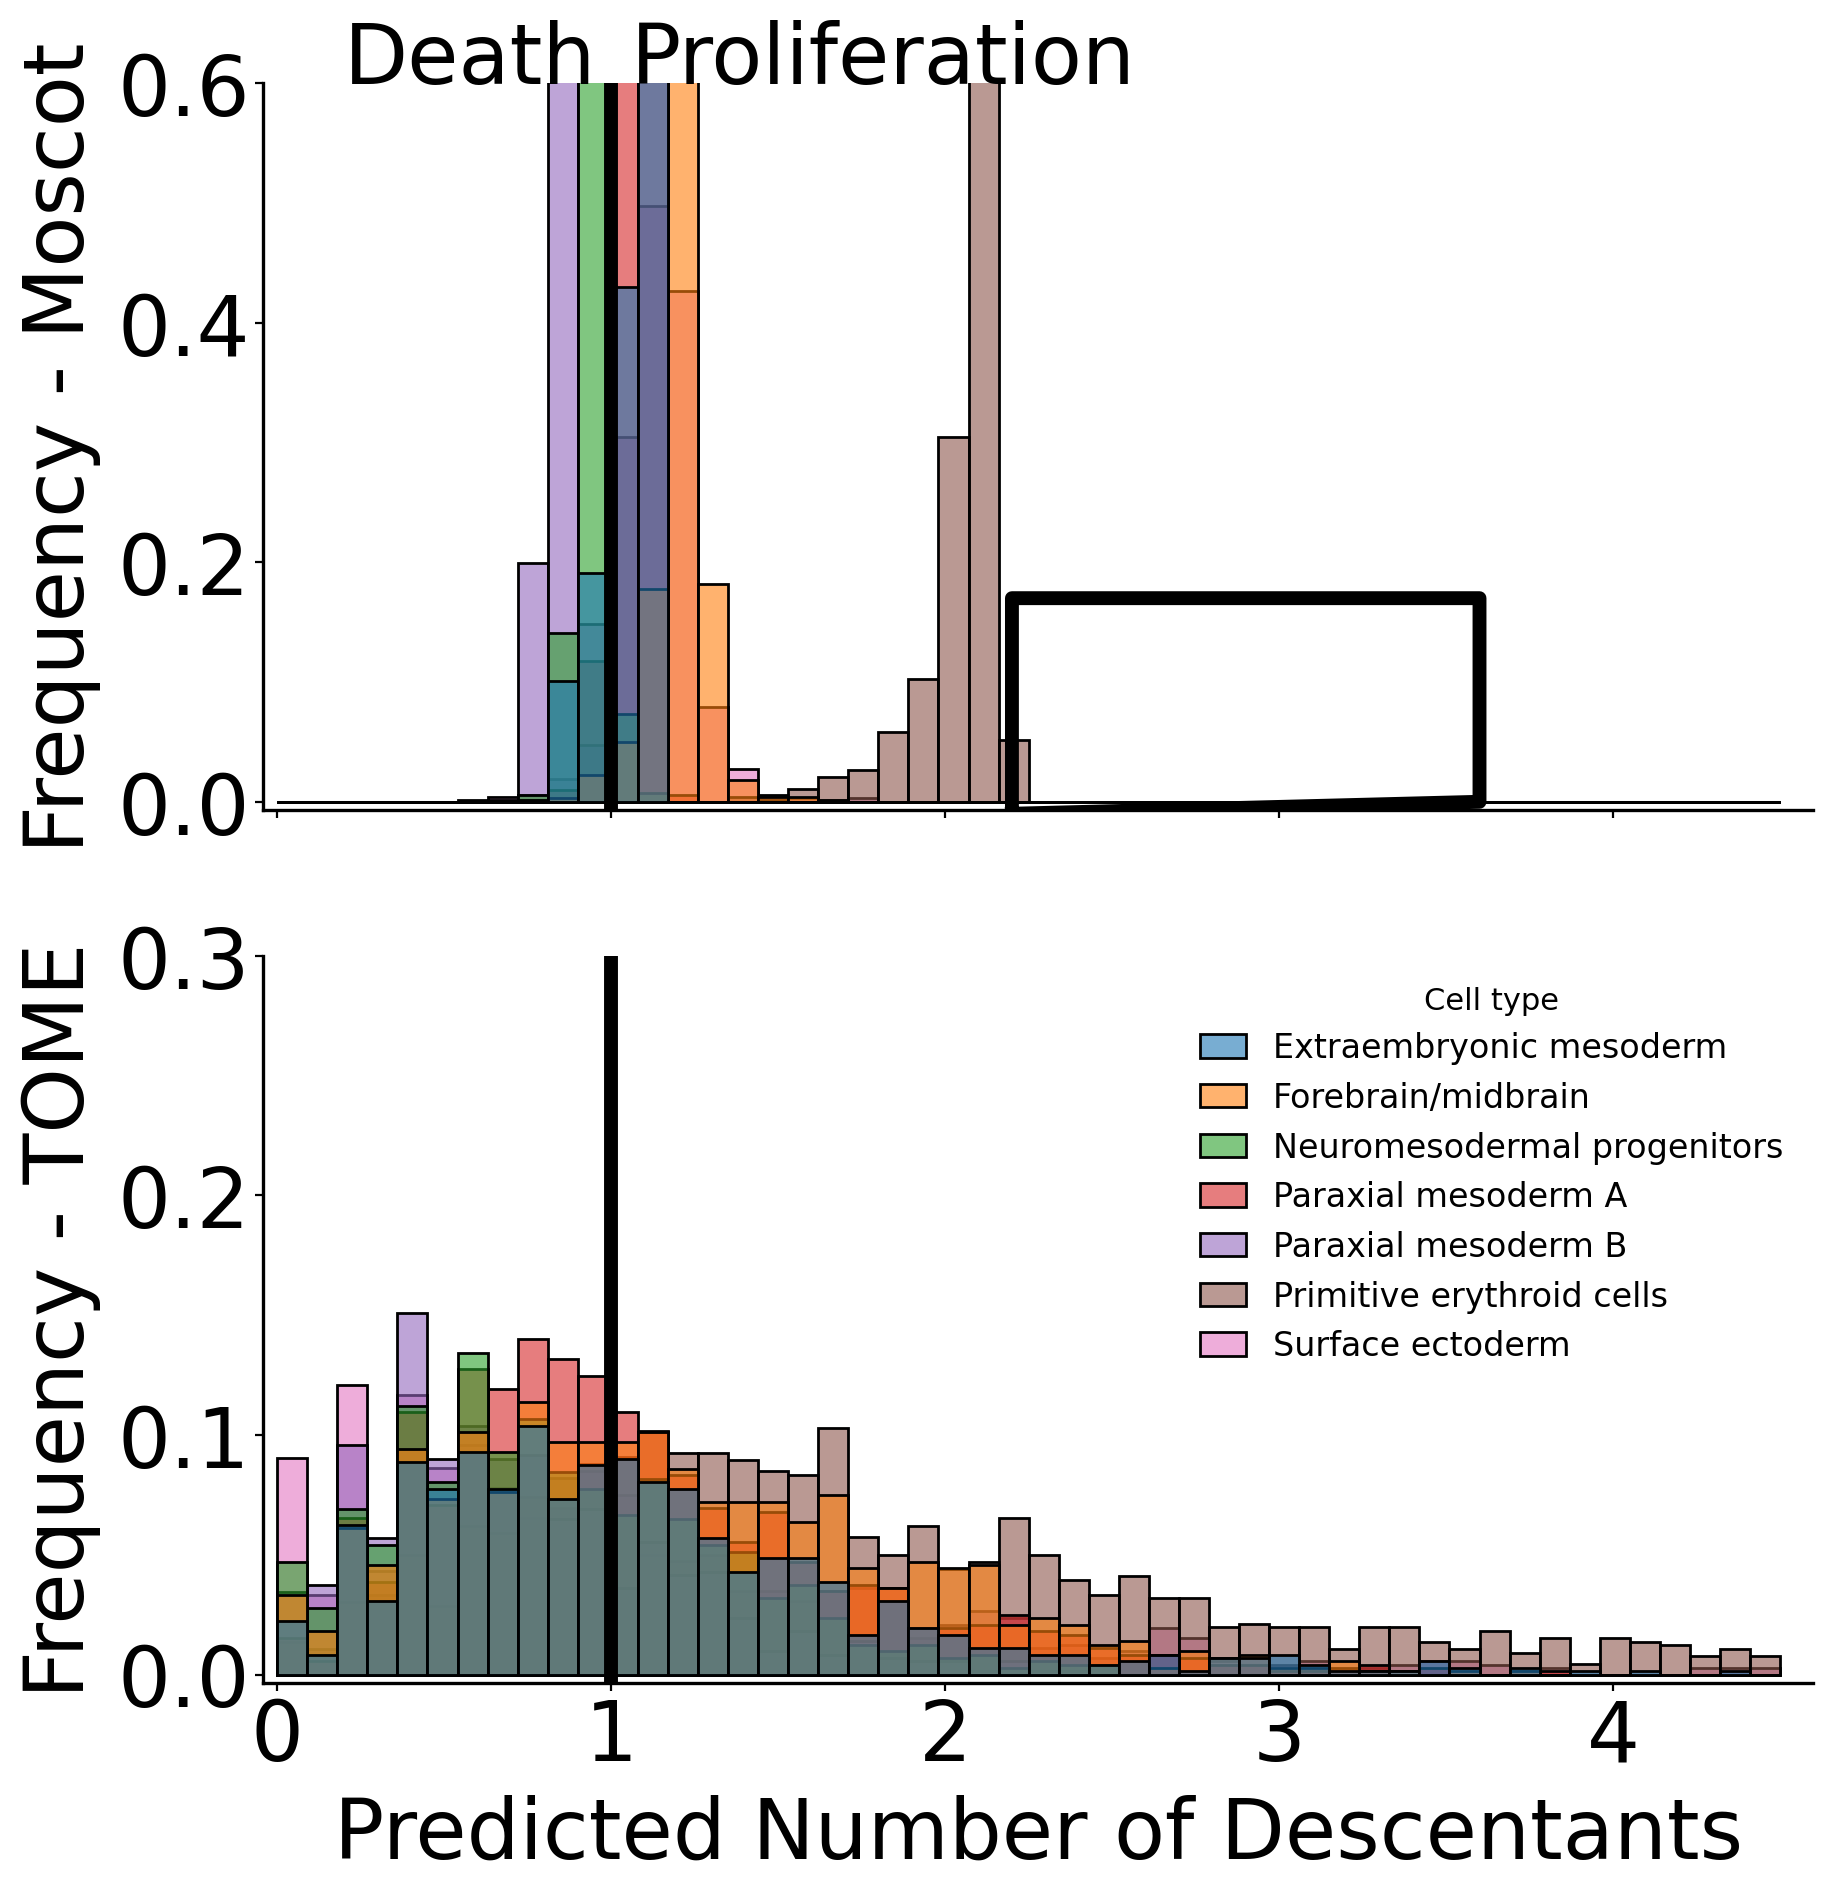

In [92]:
fontsize=30

xlim=4.5
alpha=0.6
linewidth=5

xl=2.2
xr=3.6


plt.figure(figsize = [10, 8], dpi=200)

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1

plt.subplots_adjust(bottom=0, top=1, hspace=0.2)

g1=sns.histplot(data=dfms, x='Predicted Number of Descentants', hue='Cell type', bins=np.linspace(0,xlim,51),
                alpha=alpha, legend=False, stat='density')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.tick_params(axis='both', which='major', labelsize=fontsize)

ylabel_name='Frequency'
plt.plot([xl,xr,xr,xl,xl], [-0.01,0,0.17,0.17,-0.01], color='black', linestyle='solid', linewidth=linewidth)

plt.ylabel(ylabel_name+ ' - Moscot', fontsize=fontsize)

ylim_t=0.3
ylim_m=0.6


plt.ylim(-ylim_m*0.012,ylim_m)
plt.xlim(-0.01*4.1,xlim+0.1)

#plt.text(x=-0.8,y=145,s='TOME', rotation='vertical', color=pal[1], fontsize=20, weight="bold")
plt.text(x=1.06,y=ylim_m*1.0,s='Proliferation', color='black', fontsize=fontsize)
plt.text(x=0.2,y=ylim_m*1.0,s='Death', color='black', fontsize=fontsize)


plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
g2=sns.histplot(data=dfts, x='Predicted number of descentants', hue='Cell type',
                bins=np.linspace(0,xlim,51), alpha=alpha,stat='density', legend=True)

plt.ylabel(ylabel_name+ ' - TOME', fontsize=fontsize)
plt.xlabel('Predicted Number of Descentants', fontsize=fontsize)


#plt.text(x=-1.2,y=255,s='Moscot', rotation='vertical', color='black', fontsize=fontsize+2, weight="bold")
#plt.text(x=2.95, y=ylim_m*0.8,s='Moscot', color='black', fontsize=fontsize+4, weight="bold")


g2.tick_params(axis='both', which='major', labelsize=fontsize)

plt.ylim(-ylim_t*0.012,ylim_t)
plt.xlim(-0.01*4.1,xlim+0.1)

xl=2.2
xr=4

#plt.text(x=-0.2, y=0.73, s='Growth rates: E7.0 to E7.25', color='black', fontsize=fontsize+4, weight="bold")
plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

#sns.move_legend(obj=g2, loc=(1.03,0.6), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize,
#               fancybox=True, frameon=True)

#sns.move_legend(obj=g2, loc=(1.03,0.55), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize)

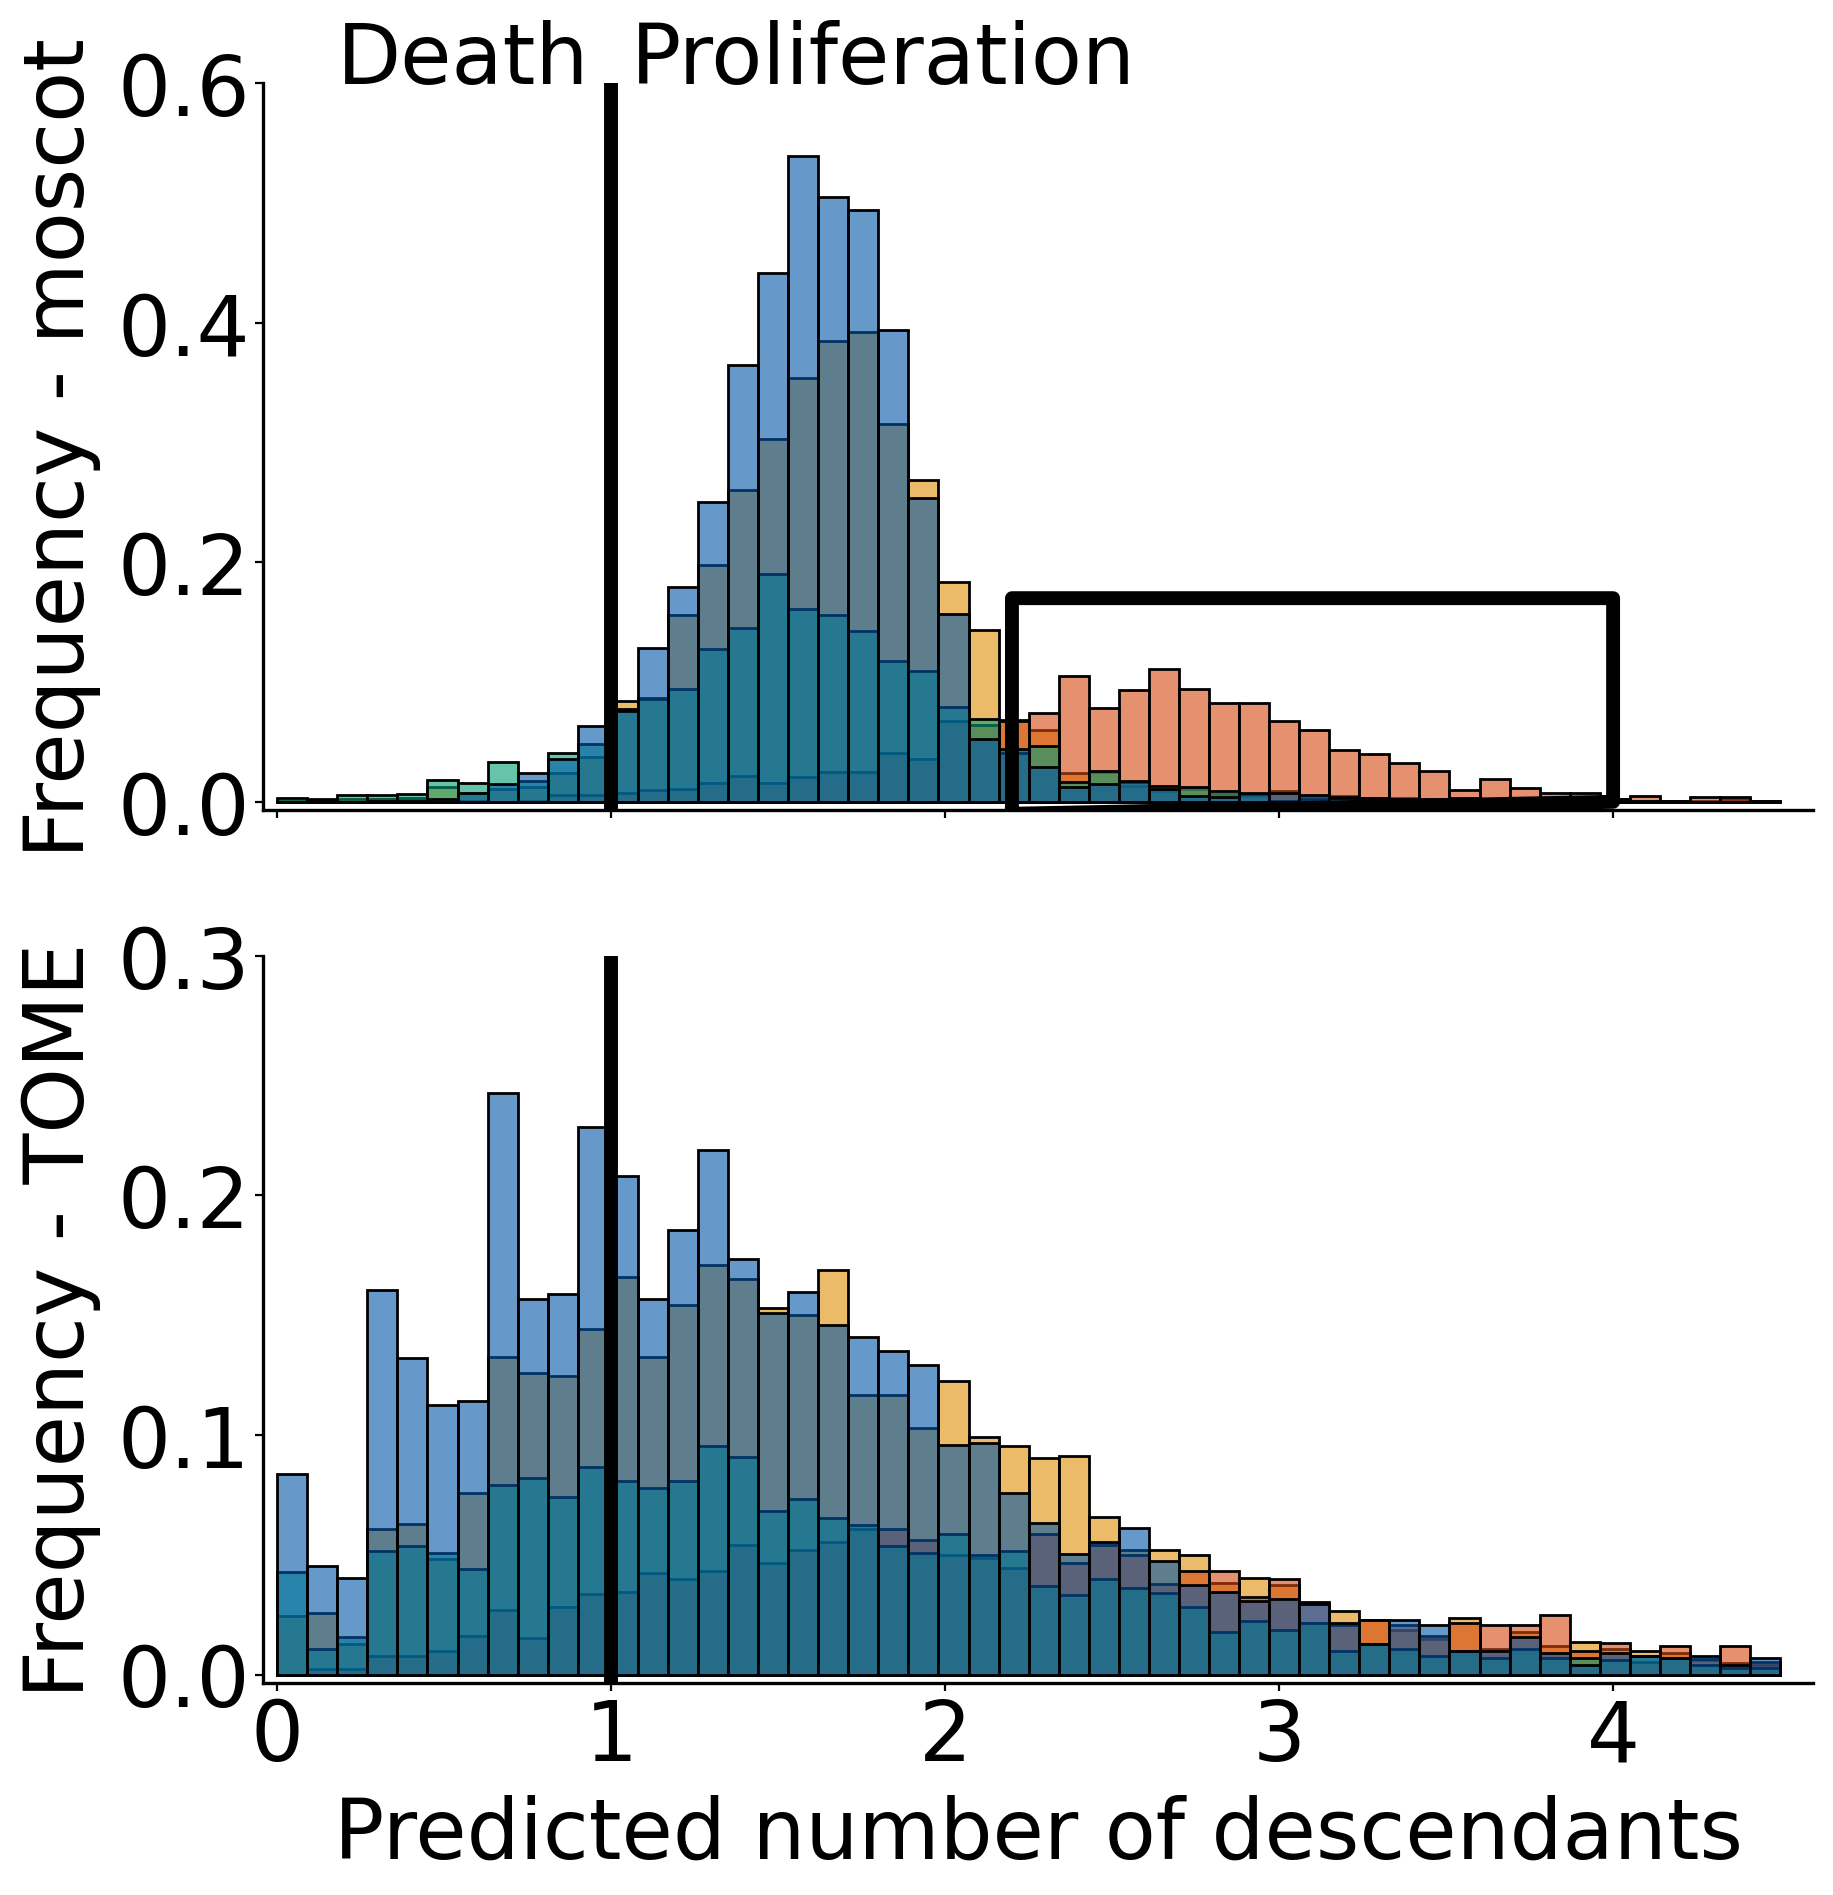

In [17]:
fontsize=30
linewidth=5

xlim=4.5
alpha=0.6


plt.figure(figsize = [10, 8], dpi=200)

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1

plt.subplots_adjust(bottom=0, top=1, hspace=0.2)

g1=sns.histplot(data=dfms, x='Predicted Number of Descentants', hue='Cell type', bins=np.linspace(0,xlim,51), 
                palette=pal,alpha=alpha, legend=False, stat='density')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.tick_params(axis='both', which='major', labelsize=fontsize)

ylabel_name='Frequency'
plt.plot([xl,xr,xr,xl,xl], [-0.01,0,0.17,0.17,-0.01], color='black', linestyle='solid', linewidth=linewidth)

plt.ylabel(ylabel_name+ ' - moscot', fontsize=fontsize)

ylim_t=0.3
ylim_m=0.6


plt.ylim(-ylim_m*0.012,ylim_m)
plt.xlim(-0.01*4.1,xlim+0.1)

#plt.text(x=-0.8,y=145,s='TOME', rotation='vertical', color=pal[1], fontsize=20, weight="bold")
plt.text(x=1.06,y=ylim_m*1.0,s='Proliferation', color='black', fontsize=fontsize)
plt.text(x=0.18,y=ylim_m*1.0,s='Death', color='black', fontsize=fontsize)


plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
g2=sns.histplot(data=dfts, x='Predicted Number of Descentants', hue='Cell type',
                bins=np.linspace(0,xlim,51), palette=pal,alpha=alpha,stat='density', legend=False)

plt.ylabel(ylabel_name+ ' - TOME', fontsize=fontsize)
plt.xlabel('Predicted number of descendants', fontsize=fontsize)


#plt.text(x=-1.2,y=255,s='Moscot', rotation='vertical', color='black', fontsize=fontsize+2, weight="bold")
#plt.text(x=2.95, y=ylim_m*0.8,s='Moscot', color='black', fontsize=fontsize+4, weight="bold")


g2.tick_params(axis='both', which='major', labelsize=fontsize)

plt.ylim(-ylim_t*0.012,ylim_t)
plt.xlim(-0.01*4.1,xlim+0.1)

xl=2.2
xr=4

#plt.text(x=-0.2, y=0.73, s='Growth rates: E7.0 to E7.25', color='black', fontsize=fontsize+4, weight="bold")
plt.plot([1,1], [-0.1,1], color='black', linestyle='solid',linewidth=linewidth)

#sns.move_legend(obj=g2, loc=(1.03,0.6), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize,
#               fancybox=True, frameon=True)

#sns.move_legend(obj=g2, loc=(1.03,0.55), ncol=1, title_fontsize=fontsize, title_weight='bold', fontsize=fontsize)